In [1]:
# import packages
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from scipy.stats import chisquare

"""
IMPORTANT:
For this program to work the researcher needs to put both csv files
cycle1.csv and cycle2.csv in a folder called Observations. Run
DownloadMongoDB.ipynb to get the files. You will have to manually
put these new files in the Observations folder which will be located
in the same folder as this file.
"""

"""
Headers for Cycle1 DF (Northern Hemisphere):
_id, Original_Object_ID, MDJ, Magnitude, Magnitude_Error

Cycle1 Size: 28878 Asteroids

Headers for Cycle2 DF (Southern Hemisphere):
_id, Object_ID, MDJ, Magnitude, Magnitude_Error, Sector

Cycle2 Size: 18712 Asteroids

Overlap Size: 3025 Asteroids
"""

# import data from csv file into a pandas df
cycle1_df = pd.read_csv("Observations/cycle1.csv", low_memory=False)
cycle2_df = pd.read_csv("Observations/cycle2.csv", low_memory=False)

# get the ids that intersect
cycle1_df_unique = np.unique(cycle1_df["Original_Object_ID"])
cycle2_df_unique = np.unique(cycle2_df["Object_ID"])
intersect_ids_df = np.intersect1d(cycle1_df_unique, cycle2_df_unique)

# define sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset

def chi_square(observed, expected, error):

    chi2 = 0

    for observation in range(0, len(observed)):
        chi2 += ((observed[observation] - expected[observation]) ** 2) / error[observation]

    return chi2

In [2]:
def compare_cycles(cycle1_df, cycle2_df, intersect_ids_df):

    # initialize output df
    columns = ["cycle", "asteroid_id", "verdict", "period (hr)", "amplitude"]

In [ ]:
def find_cycle_asteroids_light_curve_fit(cycle_df, id_col_name, cycle_num):

    # initialize output df
    columns = ["cycle", "asteroid_id", "verdict", "period (hr)", "amplitude"]
    results_df = pd.DataFrame(columns=columns)

    # group each asteroid by their object id
    asteroids = cycle_df.groupby(id_col_name)

    count = 0

    # plot each asteroid (TODO: multithread this)
    for object_id, asteroid in asteroids:

        """
        Derive the rotational period of an object from MDJ
        and Magnitude.
        """

        error = asteroid["Magnitude_Error"].values

        # extract MJD, magnitude, magnitude error
        time_mdj = asteroid["MJD"].values
        magnitude = asteroid["Magnitude"].values
        error = asteroid["Magnitude_Error"].values

        # define frequency range (1 to 24 hours period = 1/24 to 1 cycles/hour)
        # convert MJD to hours relative to first timestamp
        time_hours = (time_mdj - time_mdj.min()) * 24
        frequency = np.linspace(1/(max(time_hours) - min(time_hours)), 1/2, 1000000)
        power = LombScargle(time_hours, magnitude, error).power(frequency)

        # best period is 1 / frequency at peak power
        peak_index = np.argmax(power)
        peak_power = power[peak_index]
        best_frequency = frequency[np.argmax(power)]
        best_period = 1 / best_frequency

        # double the period for full rotation
        best_period = best_period * 2

        # create a lomb scargle model generating a sine curve fit
        ls = LombScargle(time_hours, magnitude, error)
        magnitude_fit_smooth = ls.model(time_hours, best_frequency)
        time_fit = np.linspace(0, best_period, len(magnitude))
        magnitude_fit = ls.model(time_fit, best_frequency)
        phase = (time_hours % best_period)

        """
        IMPORTANT:
        best_period is the period
        amplitude is calculated below
        """

        # find the max and mind of magnitude fit for the amplitude
        amplitude = max(magnitude_fit) - min(magnitude_fit)

        # determine how well the model fits the data (use the power value (max) and the chi squared value)
        chi2_statistic = chi_square(magnitude, magnitude_fit, error)
        score = (peak_power + 1E-6) / (chi2_statistic + 1E-6)
        print(f"Chi2: {chi2_statistic}")
        print(f"PeakPower: {peak_power}")
        print(f"Score: {score}")

        # TODO: is this interesting or not? - interesting, not interesting, garbage

            # fewer than 50? Throw out

        # add data to the output dataframe
        fit = ... #TODO: add the value of INTERESTING, NORMAL, GARBAGE
        results_df.loc[len(results_df)] = [cycle_num, object_id, fit, best_period, amplitude]

        """
        Plot the periodogram and the lomb scargle model (Commented out)
        """

        print(time_fit)
        print("=========================")
        print(phase)

        # plot the periodogram
        plt.plot(frequency, power)
        plt.show()

        # plot the lomb scargle model need to add the magnitude fit
        plt.plot(time_fit, magnitude_fit, color = "orange", linewidth = 3)
        plt.scatter(phase, magnitude, color="blue")
        plt.title(f"Light Curve Phase for: {object_id}")
        plt.xlabel("Hours")
        plt.ylabel("Magnitude")
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.show()

        """
        Plotting the raw time series data (Commented out)
        """

        # plot the timeseries data
        # plt.errorbar(asteroid["MJD"], asteroid["Magnitude"], yerr = asteroid["Magnitude_Error"], 
        #              fmt = "o", ecolor = "red", color = "orange", elinewidth = 1, capsize = 2)
        # plt.title(f"Magnitude vs MJD for Object ID {object_id}")
        # plt.xlabel("MJD")
        # plt.ylabel("Magnitude")
        # plt.gca().invert_yaxis()
        # plt.grid(True)
        # plt.show()

        count += 1

        # display the first 10
        if count > 0:
            break

    return results_df


Chi2: 230.3881348412869
PeakPower: 0.6650512834399298
Score: 0.0028866602918219742
[0.         0.02554299 0.05108597 0.07662896 0.10217195 0.12771493
 0.15325792 0.17880091 0.20434389 0.22988688 0.25542987 0.28097285
 0.30651584 0.33205883 0.35760181 0.3831448  0.40868779 0.43423077
 0.45977376 0.48531675 0.51085973 0.53640272 0.56194571 0.58748869
 0.61303168 0.63857467 0.66411765 0.68966064 0.71520363 0.74074661
 0.7662896  0.79183259 0.81737557 0.84291856 0.86846155 0.89400454
 0.91954752 0.94509051 0.9706335  0.99617648 1.02171947 1.04726246
 1.07280544 1.09834843 1.12389142 1.1494344  1.17497739 1.20052038
 1.22606336 1.25160635 1.27714934 1.30269232 1.32823531 1.3537783
 1.37932128 1.40486427 1.43040726 1.45595024 1.48149323 1.50703622
 1.5325792  1.55812219 1.58366518 1.60920816 1.63475115 1.66029414
 1.68583712 1.71138011 1.7369231  1.76246608 1.78800907 1.81355206
 1.83909504 1.86463803 1.89018102 1.915724   1.94126699 1.96680998
 1.99235296 2.01789595 2.04343894 2.06898192 2.

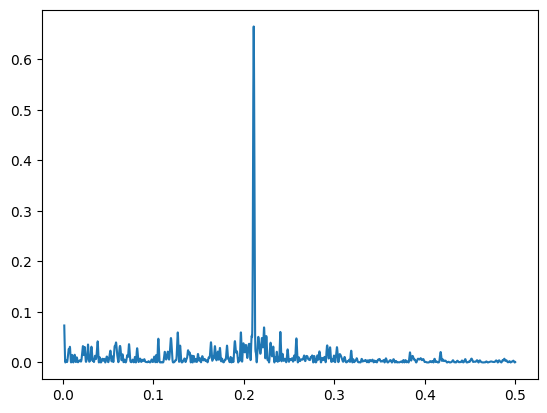

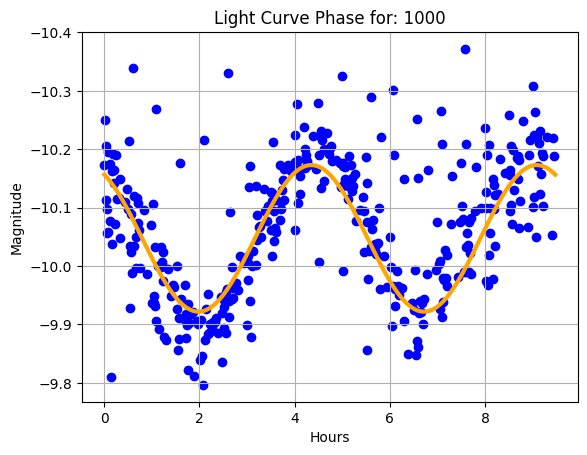

In [13]:
cycle1_results_df = find_cycle_asteroids_light_curve_fit(cycle1_df, "Original_Object_ID", 1)
# cycle2_results_df = find_cycle_asteroids_light_curve_fit(cycle2_df, "Object_ID", 2)

# print(cycle1_results_df)
# print(cycle2_results_df)